<a href="https://colab.research.google.com/github/jinayou/abmcore/blob/main/ABMcore_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2023.12.16

- Trading preference formula: Dirichlet
- Spreading preference:
    - Successful traders spread their trading strategies
    - Either: 1) choose unique strategies from winning strategies (remove those already chosen) or 2) there can be overlap (possible for certain trading strategies to be more popular)
    - When num of opinion groups increases, chose additional new preferences randomly
- Redistribution:
    - Redistribute preferences when opinion groups converge (can adjust redstribute_threshold %)
    - Does NOT use determine_distributed_earnings


In [ ]:
pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.1/241.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install powerlaw

In [ ]:
import mesa
import math
import random
import numpy as np
import copy

In [ ]:
class TraderAgent(mesa.Agent):

    def __init__(self, unique_id, model, p_hold):
        super().__init__(unique_id, model)
        self.trading_preference = self.dirichlet_trading_preference()
        self.latest_trading_decision = 0
        self.earnings = 0
        self.historical_earnings = []

    ## Trading prefrence formulas ##
    def dirichlet_trading_preference(self):
        return np.random.dirichlet(np.ones((3,), dtype=int), size=1)[0].tolist() # Choose 3 random nums that add up to 1

    def velocity_adj_trading_preference(self, p_hold): # Choose 2 random nums that add up to p_trade
        p_trade=1-p_hold
        p_buy=random.uniform(0, p_trade)
        p_sell=p_trade-p_buy
        return [p_buy, p_sell, p_hold]

    # Generate trading decisions based on probabilities
    def trade(self):
        decision = random.choices([1, -1, 0], weights=self.trading_preference, k=1)[0]
        #1=buy, -1=sell, 0=hold
        return decision


    def step(self):
        self.latest_trading_decision = self.trade()
        # self.historical_earnings.append(self.find_latest_earnings())

        # print(f"Agent {self.unique_id}'s trading preferences: {self.trading_preference}")
        # print(f"Agent {self.unique_id}'s trading decision: {self.latest_trading_decision}")


In [ ]:
class TradingModel(mesa.Model):

    def __init__(self, N, omega, sensitivity, p_hold, redistribute_threshold): #set self.p_hold = h
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        self.data_collector = mesa.datacollection.DataCollector(
            agent_reporters={"Latest Trading Decision": "latest_trading_decision"},
            model_reporters={"Traders' Decisions": "agent_decisions", "Returns": "returns_list"}
        )
        self.returns_list = [] #total return
        self.earnings_list = [] #for each agent
        self.latest_return = sum(agent.latest_trading_decision for agent in self.schedule.agents)*sensitivity
        self.p_hold = p_hold
        self.current_step=1
        self.previous_num_opinion_groups = N

        # Add the agent to the scheduler
        for i in range(self.num_agents):
            self.schedule.add(TraderAgent(i, self, p_hold))

    ## Trading prefrence formulas ##
    def dirichlet_trading_preference(self):
        return np.random.dirichlet(np.ones((3,), dtype=int), size=1)[0].tolist() # Choose 3 random nums that add up to 1

    def velocity_adj_trading_preference(self, p_hold): # Choose 2 random nums that add up to p_trade
        p_trade=1-p_hold
        p_buy=random.uniform(0, p_trade)
        p_sell=p_trade-p_buy
        return [p_buy, p_sell, p_hold]


    ## Earnings ##
    def update_agent_earnings_history(self):
        for agent in self.schedule.agents:
          agent.update_historical_earnings()

    def compile_earnings_list(self): #create a list of latest (non-distributed) earnings for all agents
        temp_list=[]
        for agent in self.schedule.agents:
          agent.earnings = -self.latest_return*agent.latest_trading_decision #choose which (buyer/seller) is the winner
          temp_list.append(agent.earnings)
        self.earnings_list = temp_list

    def determine_distributed_earnings(self): #returns
        num_profited = 0
        for agent in self.schedule.agents:
          if -agent.latest_trading_decision*self.latest_return > 0:  #choose which (buyer/seller) is the winner
            num_profited +=1
        # print('Number of Traders who Profited: ', num_profited)

        if num_profited !=0:
          distributed_return = abs(self.latest_return / num_profited)
        else:
          distributed_return = 0
        print('Distributed Return: ', distributed_return)

        return distributed_return

    ## Preferences ##
    def assign_new_preferences(self, total_r, p_hold, redistribute_threshold):

        #Determine number of opinion groups
        if total_r != 0:
            num_opinion_groups = int((self.num_agents / (abs(total_r)))**omega)
        else:
            num_opinion_groups = int(self.num_agents)
        # print("new number of opinion groups: ", num_opinion_groups)

        # Randomly distribute preferences onces opinion groups converge to a % of total traders.
        # Make this adaptable to each agent's earnings by using determine_distributed_earnings(self)
        if num_opinion_groups <= (self.num_agents*redistribute_threshold):
            print('Opinions have converged to', redistribute_threshold*100, '% of traders or less')
            for agent in self.schedule.agents:
              agent.trading_preference = agent.dirichlet_trading_preference()
            return
        else:
            self.spread_preferences(num_opinion_groups, p_hold)

    def spread_preferences(self, num_opinion_groups, p_hold):
    #Spread preferences based on whoever was successful in last iteration. If we run out of successful agents, create new preferences.

        self.compile_earnings_list()

        # Find indices of successful agents from last iteration
        successes = []

        for i in range(len(self.earnings_list)):
          if self.earnings_list[i] > 0:
            successes.append(i)

        trading_preferences = [] # Successful trading preferences

        # if number of opinion groups decreased, choose from winning strategies
        for i in range(min(num_opinion_groups, self.previous_num_opinion_groups)):
            if i < len(successes):
              choice = successes.pop(random.randrange(len(successes))) # No overlap
              # choice = random.choice(successes) # There can be overlap. Probably twice as more likely to choose the same trading preference
              trading_preferences.append(self.schedule.agents[choice].trading_preference)
            else:
              trading_preferences.append(self.dirichlet_trading_preference())

        # if number of opinion groups increases, append new random preference to make up difference
        for i in range(num_opinion_groups - self.previous_num_opinion_groups):
            trading_preferences.append(self.dirichlet_trading_preference())

        print(trading_preferences)

        self.previous_num_opinion_groups = num_opinion_groups

        # Assign agents evenly to the opinion groups
        for i in range(self.num_agents):
          self.schedule.agents[i].trading_preference = trading_preferences[i % num_opinion_groups]


    def step(self):
        print("-------------------------Beginning of step", self.current_step)
        self.current_step+=1

        # Advance the model by one step
        self.assign_new_preferences(self.latest_return/sensitivity, self.p_hold, redistribute_threshold)
        self.schedule.step()

        self.data_collector.collect(self)
        agent_decisions = [agent.latest_trading_decision for agent in self.schedule.agents]
        # print("Traders' Decisions:", agent_decisions)

        # Calculate and store the cumulative trading decisions from all agents
        self.latest_return = sum(agent.latest_trading_decision for agent in self.schedule.agents)*sensitivity
        print("Return:", self.latest_return)
        self.returns_list.append(self.latest_return)
        # print("Historical Returns:", self.returns_list)

        self.determine_distributed_earnings()

        self.compile_earnings_list()

In [ ]:
### RUN MODEL ###

## Parameters

#Sensitivity to price change
sensitivity = 1

#Power of omega term
omega = 1 #Check if omega is incorporated correctly

#Trading velocity
V=1.64
Vf=0.4
Vc=(V - 0.83*Vf)/(1- 0.83)
print(Vc)

#Daily trading probability
p=Vc/(250*2)
q=p
#h=1-p-q


## Run

p_hold=0.4
redistribute_threshold = 0.2

model = TradingModel(1000, omega, sensitivity, p_hold, redistribute_threshold) #Number of traders
for i in range(3627): #Number of time steps
    model.step()

print("Returns at Each Step:", model.returns_list)

#Test
# print(model.schedule.agents[1].historical_earnings)

Streaming output truncated to the last 5000 lines.
Opinions have converged to 20.0 % of traders or less
Return: 16
Distributed Return:  0.04984423676012461
-------------------------Beginning of step 2379
Opinions have converged to 20.0 % of traders or less
Return: -35
Distributed Return:  0.1111111111111111
-------------------------Beginning of step 2380
Opinions have converged to 20.0 % of traders or less
Return: 8
Distributed Return:  0.023880597014925373
-------------------------Beginning of step 2381
Opinions have converged to 20.0 % of traders or less
Return: 8
Distributed Return:  0.024615384615384615
-------------------------Beginning of step 2382
Opinions have converged to 20.0 % of traders or less
Return: -16
Distributed Return:  0.048484848484848485
-------------------------Beginning of step 2383
Opinions have converged to 20.0 % of traders or less
Return: -37
Distributed Return:  0.1167192429022082
-------------------------Beginning of step 2384
Opinions have converged to 20

In [ ]:
output_returns = model.returns_list

ANALYSIS

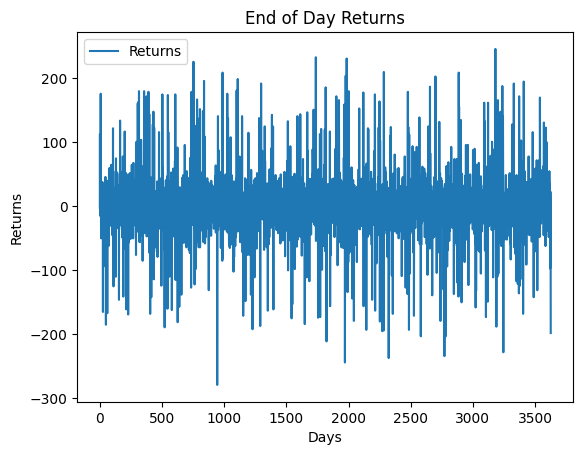

<ipython-input-8-0ef98bcf7cfe>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output_returns, hist=True, kde=False,


[2, 113, 5, 33, 15, 16, 4, 176, 6, 2, 50, 9, 35, 10, 35, 25, 9, 21, 5, 2, 29, 38, 25, 18, 4, 165, 17, 7, 2, 94, 30, 35, 26, 24, 20, 44, 2, 73, 20, 26, 14, 5, 17, 2, 8, 46, 2, 11, 4, 185, 2, 18, 15, 19, 4, 151, 16, 40, 11, 4, 167, 10, 14, 10, 15, 7, 23, 44, 19, 15, 62, 33, 11, 18, 57, 8, 27, 29, 60, 13, 43, 6, 38, 32, 22, 23, 12, 21, 17, 26, 25, 20, 65, 31, 18, 2, 36, 29, 48, 14, 18, 45, 7, 23, 20, 2, 122, 21, 55, 3, 125, 9, 26, 18, 28, 11, 15, 14, 13, 13, 25, 19, 29, 16, 20, 34, 22, 2, 110, 2, 75, 9, 10, 15, 8, 15, 5, 27, 34, 53, 24, 10, 33, 33, 29, 30, 14, 29, 18, 30, 32, 2, 8, 3, 146, 23, 9, 15, 15, 9, 29, 51, 4, 134, 12, 31, 30, 28, 7, 15, 18, 25, 25, 8, 31, 14, 31, 15, 36, 23, 54, 2, 49, 35, 2, 78, 36, 8, 2, 141, 16, 5, 2, 33, 17, 44, 18, 18, 7, 3, 117, 14, 2, 66, 52, 30, 19, 42, 5, 17, 2, 52, 4, 161, 50, 22, 12, 15, 23, 5, 17, 2, 21, 11, 12, 5, 29, 3, 169, 11, 57, 33, 23, 8, 35, 38, 39, 50, 25, 30, 23, 52, 12, 33, 17, 27, 21, 51, 20, 29, 7, 24, 24, 15, 38, 21, 47, 65, 27, 19, 2, 3

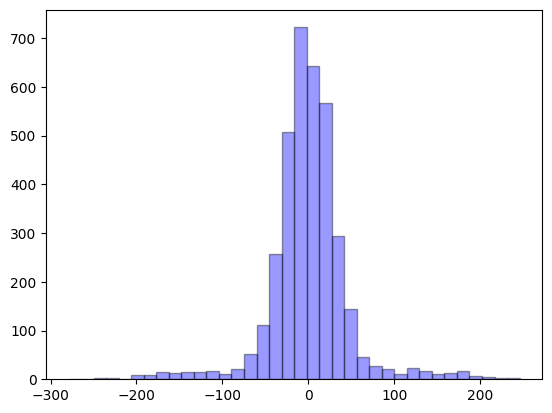

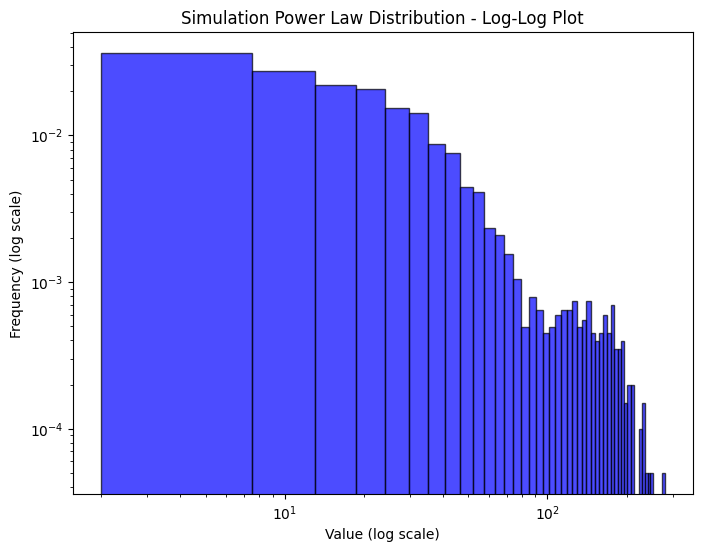

[INFO] computing Hill Estimators...
2

Sample size n: 3627
Total number of exceeded k: 3626
kap_gains_sim 7.085660744203867


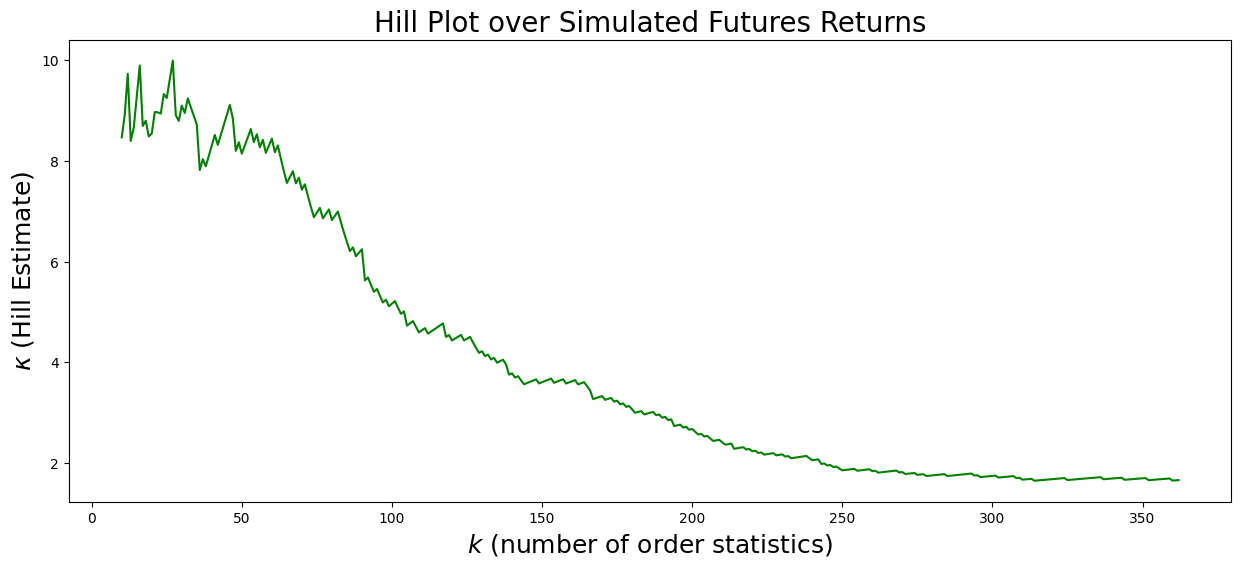

In [ ]:
import matplotlib.pyplot as plt
import powerlaw
import pandas as pd
import seaborn as sns

## PLOT SIMULATION ##

# Plot returns
plt.plot(output_returns, label='Returns')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.title('End of Day Returns')
plt.legend()
plt.show()

# Histogram
sns.distplot(output_returns, hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

#Option 1
'''data=[]
for i in output_returns:
  data.append(abs(i))
print(data)'''

#Option 2
data=[]
for i in output_returns:
  if abs(i)<2:
    data.append(2)
  else:
    data.append(abs(i))
print(data)

#Option 3
'''data=[]
for i in output_returns:
  if i== 0:
    data.append(0.1)
  else:
    data.append(abs(i))
print(data)'''


# Plot returns on a log-log scale
plt.figure(figsize=(8, 6))
plt.hist(data, bins=50, density=True, alpha=0.7, color='blue', edgecolor = 'black')
plt.xscale('log')
plt.yscale('log')
plt.title('Simulation Power Law Distribution - Log-Log Plot')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()



### Hill Estimator FOR SIMULATION
# code found on GitHub under the profile AlinaSode

def Hill_estimator(data):
    """
    Returns the Hill Estimators for some 1D data set.
    """
    # sort data in such way that the smallest value is first and the largest value comes last:
    Y = np.sort(data)
    n = len(Y)

    Hill_est = np.zeros(n-1)

    for k in range(0, n-1):    # k = 0,...,n-2
        summ = 0

        for i in range(0,k+1):   # i = 0, ..., k
            summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])

        Hill_est[k] = (1 / (k+1)) * summ      # add 1 to k because of Python syntax

    kappa = 1. / Hill_est
    return kappa


n_obs = len(data)
k_max = int(round(0.1*n_obs))
k_min = 10

print("[INFO] computing Hill Estimators...")
#t0 = time()
print(min(data))
kap_gains_sim = Hill_estimator(data)

#print ("        done in %0.3f minutes" % ((time() - t0)/60))
print ("")

print ("Sample size n:", n_obs)
print ("Total number of exceeded k:", len(kap_gains_sim))
print('kap_gains_sim', kap_gains_sim[72])


""" Hill Plot for Gains for k in range (10,...,round(0.1*n_obs)) """

plt.figure(figsize=(15, 6))
plt.plot(np.arange(k_min,k_max), kap_gains_sim[k_min-1:k_max-1], 'green')
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\kappa$ (Hill Estimate)", fontsize=18)
plt.title("Hill Plot over Simulated Futures Returns", fontsize=20)
plt.show()

In [ ]:
## READ IN NATURAL GAS FUTURES DATA

## Load data from the drive

from google.colab import auth
auth.authenticate_user()

import gspread

# method 1
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1VMZvoSCBruftaPjW7XwjlsjZBfLdOQ3BKNY2WiC46eE/edit?usp=drive_link')
sheets = gsheets.worksheet('Natural Gas Futures Historical Data').get_all_values()
futures_data = pd.DataFrame(sheets[1:], columns=sheets[0])

# method 2
'''
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

#Path to the data will likely change for you
path = "/content/drive/MyDrive/ABMcore/Data/Gas_futures_data.gsheet"

futures_data=pd.read_csv(path)
'''

print(futures_data)

futures_data["Change"] = futures_data['Change %'].str.rstrip('%').astype('float') / 100.0
fdata = futures_data["Change"].abs()

print(fdata)

## PLOT NATURAL GAS FUTURES DATA
# Plot the data on a log-log scale
plt.figure(figsize=(8, 6))
plt.hist(fdata, bins=50, density=True, alpha=0.7, color='blue', edgecolor = 'black')
plt.xscale('log')
plt.yscale('log')
plt.title(' Energy Futures Power Law Distribution (Empirical)- Log-Log Plot')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()


In [ ]:
## HILL ESTMATOR FOR GAS FUTURES ##

n_obs = len(fdata)
k_max = int(round(0.1*n_obs))
k_min = 10

print("[INFO] computing Hill Estimators...")
#t0 = time()

kap_gains = Hill_estimator(fdata)


print ("")

print ("Sample size n:", n_obs)
print ("Total number of exceeded k:", len(kap_gains))


""" Hill Plot for Gains for k in range (10,...,round(0.1*n_obs)) """

plt.figure(figsize=(15, 6))
plt.plot(np.arange(k_min,k_max), kap_gains[k_min-1:k_max-1], 'green', label = 'Empirical')
plt.plot(np.arange(k_min,k_max), kap_gains_sim[k_min-1:k_max-1], 'blue', label = 'Simulated')
plt.legend()
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\kappa$ (Hill Estimate)", fontsize=18)
plt.title("Hill Plot over Gas Futures Returns", fontsize=20)
plt.show()
print(kap_gains_sim[0:100])
print(kap_gains[0:100])
print('kap_gains_sim', kap_gains_sim[72])
ratio = []
for i in range(100):
  ratio.append(kap_gains_sim[i]/kap_gains[i])
print(ratio)